In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import json
import yaml
from pathlib import Path

%matplotlib inline
sns.set()

2023-05-04 03:33:16.330447: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-04 03:33:16.366734: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-04 03:33:16.367526: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-04 03:33:17.291961: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


pygame 2.1.3 (SDL 2.0.22, Python 3.8.10)
Hello from the pygame community. https://www.pygame.org/contribute.html
Using TensorFlow 2.12.0


2023-05-04 03:33:22.028400: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


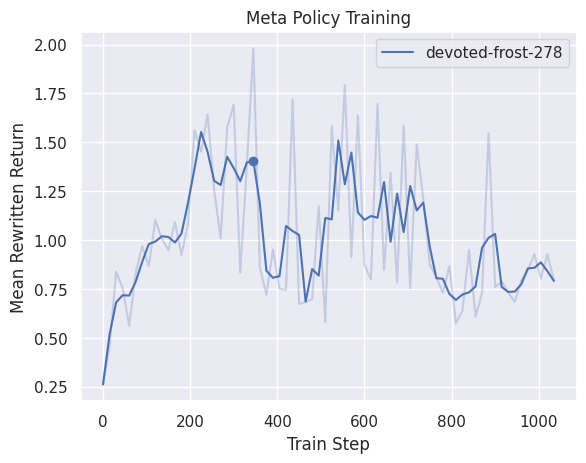

In [2]:
from mlrl.experiments.eval_procgen_meta_policies import load_best_policy, get_wandb_info_from_run_dir


run_path = Path('outputs/runs/ppo_run_48-08-23-02-05-2023/')
run_info = get_wandb_info_from_run_dir(run_path)
load_best_policy(run_info)
plt.show()

In [3]:
from pprint import pprint

pprint(run_info['config'])

{'_wandb': {'cli_version': '0.12.10',
            'framework': 'keras',
            'is_jupyter_run': False,
            'is_kaggle_kernel': False,
            'python_version': '3.8.10',
            'start_time': 1683068998,
            't': {1: [2, 3], 3: [16], 4: '3.8.10', 5: '0.12.10', 8: [5]}},
 'agent': 'ppo',
 'collect_steps': 4096,
 'computational_rewards': True,
 'env_batch_size': 64,
 'eval_interval': 15,
 'eval_steps': 1024,
 'expand_all_actions': True,
 'finish_on_terminate': True,
 'gpus': None,
 'learning_rate': 'mlrl.runners.ppo_runner.PPORunner.__init__.<locals>.learning_rate_fn',
 'max_cost_of_computation': 0.002,
 'max_tree_size': 64,
 'meta_discount': 0.99,
 'meta_time_limit': 500,
 'min_train_computation_steps': 5,
 'n_collect_envs': 64,
 'n_eval_envs': 32,
 'n_lstm_layers': 0,
 'n_video_envs': 2,
 'name': 'procgen-bigfish',
 'num_iterations': 2000,
 'num_learn_samples': 5,
 'object_discount': 0.99,
 'object_level_config': {'action_repeats': 4,
                     

In [4]:
from mlrl.experiments.procgen_meta import create_batched_procgen_meta_envs, load_pretrained_q_network
from tensorflow.keras.utils import Progbar
from mlrl.experiments.procgen_meta import reset_object_level_metrics, get_object_level_metrics
from mlrl.procgen.time_limit_observer import TimeLimitObserver
from mlrl.runners.eval_runner import EvalRunner

args = run_info['run_args']
n_object_level_episodes = 10
policy = run_info['best_policy']

percentile = run_info['config']['pretrained_percentile']

args.update({
    'pretrained_percentile': percentile,
    'expand_all_actions': True,
    'finish_on_terminate': True,
})

object_config = load_pretrained_q_network(
    folder=args['pretrained_runs_folder'],
    run=args['pretrained_run'],
    percentile=args.get('pretrained_percentile', 0.75),
    verbose=False
)

In [8]:
class TransitionObserver:

    def __init__(self, meta_env):
        self.last_tree = None
        self.meta_env = meta_env
        self.frames = [[]]
        self.infos = []
        self.episode_counter = 0

    def __call__(self, obs, reward, object_level_done, info):
        
        if self.meta_env.done:
            # self.frames[self.episode_counter].append(self.meta_env.object_env.render(mode='rgb_array'))
            # self.last_tree = self.meta_env.tree.copy()
            object_env = self.meta_env.object_env.env
            object_state = object_env.callmethod('get_state')
            self.frames[self.episode_counter].append(self.meta_env.render(mode='rgb_array'))
            object_env.callmethod('set_state', object_state)

        if object_level_done:
            self.episode_counter += 1
            self.frames.append([])
            info['reward'] = reward
            self.infos.append(info)


batched_meta_env = create_batched_procgen_meta_envs(
    n_envs=1,
    object_config=object_config,
    **args
)

meta_env = batched_meta_env.envs[0]

observer = TransitionObserver(meta_env)

n_object_level_episodes = 10
max_object_level_steps = 50

time_limit = TimeLimitObserver(meta_env, max_object_level_steps)
meta_env.object_level_transition_observers.extend([time_limit, observer])


def failed_before_time_out() -> bool:
    failed_too_early = any(
        stats['steps'] < max_object_level_steps
        for stats in meta_env.object_level_metrics.episode_stats
    )

    # {
    #     'ObjectLevelMeanReward': sum_of_returns / max(1, n_episodes),
    #     'ObjectLevelMeanStepsPerEpisode': total_steps / max(1, n_episodes),
    #     'ObjectLevelEpisodes': n_episodes,
    #     'ObjectLevelCurrentEpisodeReturn': self.return_val,
    #     'ObjectLevelCurrentEpisodeSteps': self.n_steps
    # }

    metrics = meta_env.object_level_metrics.get_results()
    n_episodes = metrics['ObjectLevelEpisodes']
    curr_steps = metrics['ObjectLevelCurrentEpisodeSteps']
    reward = metrics['ObjectLevelCurrentEpisodeReturn']
    print(f'Episode: {n_episodes:3d} | Step: {curr_steps:3d} | Reward: {reward}',
          end='\n' if failed_too_early else '\r')

    return failed_too_early


prog_bar = Progbar(
    n_object_level_episodes,
    unit_name='episode',
    stateful_metrics=['ObjectLevelMeanReward',
                        'ObjectLevelMeanStepsPerEpisode',
                        'ObjectLevelEpisodes']
)


def completed_n_episodes() -> bool:
    n_complete = sum([
        env.object_level_metrics.get_num_episodes()
        for env in batched_meta_env.envs
    ])

    metrics = get_object_level_metrics(batched_meta_env)
    prog_bar.update(n_complete, values=metrics.items())

    return n_complete >= n_object_level_episodes


eval_runner = EvalRunner(
    eval_env=batched_meta_env,
    policy=policy,
    rewrite_rewards=True,
    use_tf_function=False,
    convert_to_eager=False,
    # stop_eval_condition=failed_before_time_out
    stop_eval_condition=completed_n_episodes
)

In [9]:
reset_object_level_metrics(batched_meta_env)
eval_results = eval_runner.run()
object_level_results = get_object_level_metrics(batched_meta_env)

evaluations = {
    **args,
    **object_config,
    **eval_results,
    **object_level_results
}


 0/10 [..............................] - ETA: 0s - ObjectLevelMeanReward: 1.0000 - ObjectLevelMeanStepsPerEpisode: 10.0000 - ObjectLevelEpisodes: 1.0000

In [11]:
from mlrl.utils.render_utils import save_video, embed_mp4

embed_mp4(save_video(observer.frames[0], fps=15))

In [12]:
meta_env.object_level_metrics.episode_stats[-1]

{'return': 0.0, 'steps': 26}

Greedy Policy Trajectory: RIGHT+UP LEFT+UP


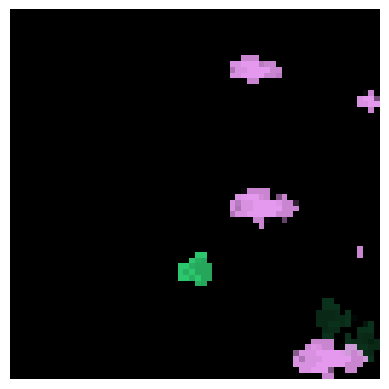

In [13]:
object_env = meta_env.object_env
observer.last_tree.root_node.state.set_environment_to_state(object_env)
tree_policy = meta_env.make_tree_policy(observer.last_tree)
print(tree_policy.__repr__(sep=' '))
# img = object_env.render(mode='rgb_array')
img = meta_env.tree_policy_renderer(object_env, tree_policy)
plt.imshow(img)
plt.axis('off')
plt.show()

In [27]:
observer.last_tree

{ProcgenState(8557844179164532678)}
|---[LEFT+DOWN, 0.000]--> {ProcgenState(3925379738679809692)}
	|---[LEFT+DOWN, 0.000]--> (ProcgenState(6881968853150167402))
	|---[LEFT, 0.000]--> (ProcgenState(-6430537914364827389))
	|---[LEFT+UP, 0.000]--> (ProcgenState(-8708330067952750298))
	|---[DOWN, 0.000]--> (ProcgenState(-2144123494325627629))
	|---[UP, 0.000]--> (ProcgenState(-1758678520612354960))
	|---[RIGHT+DOWN, 0.000]--> (ProcgenState(-2521874778541270715))
	|---[RIGHT, 0.000]--> (ProcgenState(5280834717086853685))
	|---[RIGHT+UP, 0.000]--> (ProcgenState(-1177807502120862523))
|---[LEFT, 0.000]--> {ProcgenState(-5499025719426593441)}
	|---[LEFT+DOWN, 0.000]--> (ProcgenState(-8420338251432854628))
	|---[LEFT, 0.000]--> (ProcgenState(8964112464704131702))
	|---[LEFT+UP, 0.000]--> (ProcgenState(6372994383901843315))
	|---[DOWN, 0.000]--> (ProcgenState(-4045829510596499638))
	|---[UP, 0.000]--> (ProcgenState(6187432611443212780))
	|---[RIGHT+DOWN, 0.000]--> (ProcgenState(-8214330375192613

In [25]:
observer.last_tree.root_node.children[8][0].is_terminal_state

False

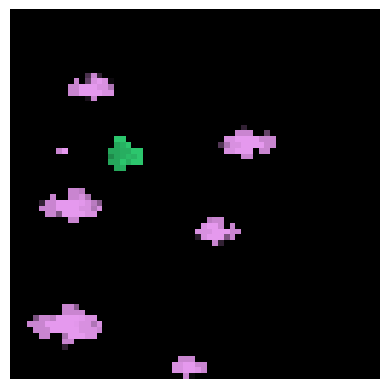

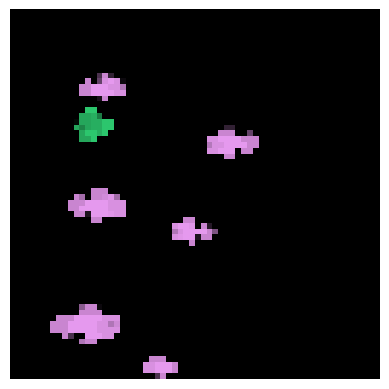

In [95]:
observer.last_tree.root_node.state.set_environment_to_state(object_env)

# tree_policy = meta_env.make_tree_policy(observer.last_tree)
# img = meta_env.tree_policy_renderer(object_env, tree_policy)
img = object_env.render(mode='rgb_array')
plt.imshow(img)
plt.axis('off')
plt.show()

time_step = object_env.step(left_down_node.action)

img = object_env.render(mode='rgb_array')
plt.imshow(img)
plt.axis('off')
plt.show()

In [83]:
tree_copy = observer.last_tree.copy()
tree_copy.node_list[1].children.clear()

In [84]:
meta_env.make_tree_policy(tree_copy)

Greedy Policy Trajectory: LEFT+DOWNLEFT+UP

In [102]:
1 + 0.99 * 24.206

24.96394

In [104]:
tree_copy

{ProcgenState(6792922126638329549)}
|---[LEFT+DOWN, 1.000, 25.131]--> {ProcgenState(8547960554304743129)}
|---[LEFT, 1.000, 24.964]--> {ProcgenState(-5858508432642135980)}
	|---[LEFT+DOWN, 0.000, 24.085]--> (ProcgenState(-6889649977319727080))
	|---[LEFT, 0.000, 24.156]--> (ProcgenState(1839278410868502683))
	|---[LEFT+UP, 0.000, 24.160]--> (ProcgenState(-4178202700555090928))
	|---[DOWN, 0.000, 24.131]--> (ProcgenState(3590959742224620116))
	|---[UP, 0.000, 24.158]--> (ProcgenState(-3326438115419568343))
	|---[RIGHT+DOWN, 0.000, 24.131]--> (ProcgenState(5096238601516035305))
	|---[RIGHT, 0.000, 24.206]--> (ProcgenState(1845299054604910017))
	|---[RIGHT+UP, 0.000, 24.107]--> (ProcgenState(8965507720104709865))
|---[LEFT+UP, 1.000, 24.976]--> {ProcgenState(4541256716709254793)}
	|---[LEFT+DOWN, 0.000, 24.140]--> (ProcgenState(-7179392251764461401))
	|---[LEFT, 0.000, 24.131]--> (ProcgenState(846147049728555857))
	|---[LEFT+UP, 0.000, 24.132]--> (ProcgenState(-2816999654728613542))
	|---

In [127]:
meta_env.make_tree_policy(observer.last_tree)

Greedy Policy Trajectory: LEFT+DOWNRIGHT+UPRIGHT+UP

In [28]:
tree_copy = observer.last_tree.copy()
meta_env.optimal_q_estimator.estimate_and_cache_optimal_q_values(tree_copy)
node = tree_copy.root_node
state_nodes = tree_copy.get_state_nodes(node.state)

In [29]:
tree_copy

{ProcgenState(8557844179164532678)}
|---[LEFT+DOWN, 0.000, 23.943]--> {ProcgenState(3925379738679809692)}
	|---[LEFT+DOWN, 0.000, 24.089]--> (ProcgenState(6881968853150167402))
	|---[LEFT, 0.000, 24.111]--> (ProcgenState(-6430537914364827389))
	|---[LEFT+UP, 0.000, 24.164]--> (ProcgenState(-8708330067952750298))
	|---[DOWN, 0.000, 23.978]--> (ProcgenState(-2144123494325627629))
	|---[UP, 0.000, 24.038]--> (ProcgenState(-1758678520612354960))
	|---[RIGHT+DOWN, 0.000, 23.976]--> (ProcgenState(-2521874778541270715))
	|---[RIGHT, 0.000, 24.179]--> (ProcgenState(5280834717086853685))
	|---[RIGHT+UP, 0.000, 24.185]--> (ProcgenState(-1177807502120862523))
|---[LEFT, 0.000, 23.912]--> {ProcgenState(-5499025719426593441)}
	|---[LEFT+DOWN, 0.000, 24.100]--> (ProcgenState(-8420338251432854628))
	|---[LEFT, 0.000, 24.153]--> (ProcgenState(8964112464704131702))
	|---[LEFT+UP, 0.000, 24.106]--> (ProcgenState(6372994383901843315))
	|---[DOWN, 0.000, 24.112]--> (ProcgenState(-4045829510596499638))
	|-

In [16]:
node = tree_copy.root_node
q_values = {
    node.state.get_action_label(action): node.get_q_value(action)
    for action in node.state.get_actions()
}
q_values, max(q_values, key=q_values.get)

({'LEFT+DOWN': 23.943372212219238,
  'LEFT': 23.911614974212647,
  'LEFT+UP': 23.949773011779786,
  'DOWN': 23.972426720088958,
  'UP': 23.889832814025876,
  'RIGHT+DOWN': 23.896130797004698,
  'RIGHT': 24.11133247375488,
  'RIGHT+UP': 24.131144256591796},
 'RIGHT+UP')

In [17]:
list(zip(node.state.q_values, node.state.get_action_labels()))

[(24.373783, 'LEFT+DOWN'),
 (24.340734, 'LEFT'),
 (24.505508, 'LEFT+UP'),
 (24.186737, 'DOWN'),
 (24.33768, 'UP'),
 (24.422493, 'RIGHT+DOWN'),
 (24.047857, 'RIGHT'),
 (24.167572, 'RIGHT+UP')]

In [135]:
meta_env.optimal_q_estimator.estimate_and_cache_optimal_q_values(observer.last_tree)
observer.last_tree

{ProcgenState(6792922126638329549)}
|---[LEFT+DOWN, 1.000, 25.013]--> {ProcgenState(8547960554304743129)}
	|---[LEFT+DOWN, 0.000, 23.890]--> {ProcgenState(-7166823489466748466)}
		|---[LEFT+DOWN, 0.000, 24.131]--> (ProcgenState(-930871717123247553))
		|---[LEFT, 0.000, 24.131]--> (ProcgenState(606717790707216611))
		|---[LEFT+UP, 0.000, 24.131]--> (ProcgenState(-3050851628359375176))
		|---[DOWN, 0.000, 24.131]--> (ProcgenState(-7191663189664968730))
		|---[UP, 0.000, 24.131]--> (ProcgenState(-7022205047494789256))
		|---[RIGHT+DOWN, 0.000, 24.131]--> (ProcgenState(8625914741293409895))
		|---[RIGHT, 0.000, 24.131]--> (ProcgenState(-5027205808535001162))
		|---[RIGHT+UP, 0.000, 24.131]--> (ProcgenState(-8631609133062992692))
	|---[LEFT, 0.000, 24.131]--> (ProcgenState(497591272452542424))
	|---[LEFT+UP, 0.000, 24.109]--> {ProcgenState(-1758128090288690491)}
		|---[LEFT+DOWN, 0.000, 24.131]--> (ProcgenState(2050481814374929288))
		|---[LEFT, 0.000, 24.252]--> (ProcgenState(-475710642280

In [123]:
max_q = max(q_values.values())
max_actions = [a for a, q in q_values.items() if q == max_q]
probs = {a: 0. for a in q_values}
for a in max_actions:
    probs[a] = 1 / len(max_actions)

probs

{'LEFT+DOWN': 0.0,
 'LEFT': 0.0,
 'LEFT+UP': 0.0,
 'DOWN': 0.0,
 'UP': 0.0,
 'RIGHT+DOWN': 0.0,
 'RIGHT': 1.0,
 'RIGHT+UP': 0.0}

In [125]:
np.random.choice(list(probs.keys()), p=list(probs.values()))

'RIGHT'

In [105]:
observer.last_tree

{ProcgenState(6792922126638329549)}
|---[LEFT+DOWN, 1.000, 23.918]--> {ProcgenState(8547960554304743129)}
	|---[LEFT+DOWN, 0.000, 24.260]--> {ProcgenState(-7166823489466748466)}
		|---[LEFT+DOWN, 0.000, 24.260]--> (ProcgenState(-930871717123247553))
		|---[LEFT, 0.000, 24.266]--> (ProcgenState(606717790707216611))
		|---[LEFT+UP, 0.000, 24.375]--> (ProcgenState(-3050851628359375176))
		|---[DOWN, 0.000, 24.207]--> (ProcgenState(-7191663189664968730))
		|---[UP, 0.000, 24.364]--> (ProcgenState(-7022205047494789256))
		|---[RIGHT+DOWN, 0.000, 24.176]--> (ProcgenState(8625914741293409895))
		|---[RIGHT, 0.000, 24.279]--> (ProcgenState(-5027205808535001162))
		|---[RIGHT+UP, 0.000, 24.328]--> (ProcgenState(-8631609133062992692))
	|---[LEFT, 0.000, 24.266]--> (ProcgenState(497591272452542424))
	|---[LEFT+UP, 0.000, 24.375]--> {ProcgenState(-1758128090288690491)}
		|---[LEFT+DOWN, 0.000, 24.343]--> (ProcgenState(2050481814374929288))
		|---[LEFT, 0.000, 24.376]--> (ProcgenState(-475710642280

In [90]:
tree_copy.node_list[1].is_terminal_state = True

In [93]:
meta_env.make_tree_policy(tree_copy)

Estimating optimal Q-values for state ProcgenState(6792922126638329549) from nodes:
{ProcgenState(6792922126638329549)}
|---[LEFT+DOWN, 1.000, 25.131]--> {ProcgenState(8547960554304743129)}
|---[LEFT, 1.000, 24.964]--> {ProcgenState(-5858508432642135980)}
	|---[LEFT+DOWN, 0.000, 24.085]--> (ProcgenState(-6889649977319727080))
	|---[LEFT, 0.000, 24.156]--> (ProcgenState(1839278410868502683))
	|---[LEFT+UP, 0.000, 24.160]--> (ProcgenState(-4178202700555090928))
	|---[DOWN, 0.000, 24.131]--> (ProcgenState(3590959742224620116))
	|---[UP, 0.000, 24.158]--> (ProcgenState(-3326438115419568343))
	|---[RIGHT+DOWN, 0.000, 24.131]--> (ProcgenState(5096238601516035305))
	|---[RIGHT, 0.000, 24.206]--> (ProcgenState(1845299054604910017))
	|---[RIGHT+UP, 0.000, 24.107]--> (ProcgenState(8965507720104709865))
|---[LEFT+UP, 1.000, 24.976]--> {ProcgenState(4541256716709254793)}
	|---[LEFT+DOWN, 0.000, 24.140]--> (ProcgenState(-7179392251764461401))
	|---[LEFT, 0.000, 24.131]--> (ProcgenState(846147049728

Greedy Policy Trajectory: LEFT+DOWNLEFT+UP

In [52]:
search_tokens = meta_env.tree_tokeniser.tokenise(observer.last_tree)

In [53]:
observation = {
    'search_tree_tokens': search_tokens,
    'action_mask': search_tokens[:, 1].astype(np.int32)
}

In [ ]:
policy

In [2]:
baselines_eval_folder = 'outputs/baseline/procgen/52-55-04-01-05-2023-complete'
learned_eval_folders = [
    'outputs/eval/procgen/41-09-18-02-05-2023',
    'outputs/eval/procgen/31-29-12-03-05-2023',
]

In [120]:
# episode_stats_df = pd.concat([
#     pd.read_csv(os.path.join(baselines_eval_folder, 'episode_stats.csv')),
#     *[pd.read_csv(os.path.join(folder, 'episode_stats.csv')) for folder in learned_eval_folders]
# ]).reset_index()

episode_stats_df = pd.concat([
    pd.read_csv(os.path.join(baselines_eval_folder, 'episode_stats.csv')),
    *[pd.read_csv(p) for p in Path('outputs/eval/procgen/final_evals').glob('episode_stats*')]
]).reset_index()

# for consistent hue order
policy_order = episode_stats_df['Meta-level Policy'].unique()

# results_df = pd.concat([
#     pd.read_csv(os.path.join(baselines_eval_folder, 'results.csv')),
#     pd.read_csv(os.path.join(learned_eval_folders[0], 'results2.csv')),
#     *[pd.read_csv(os.path.join(folder, 'results.csv')) for folder in learned_eval_folders]
# ]).reset_index()

In [10]:
episode_stats_df.head()

,index,Meta-level Policy,Pretrained Percentile,Number of Steps,Return
0,0,Instant Terminate,0.25,10,0.0
1,1,Instant Terminate,0.25,24,2.0
2,2,Instant Terminate,0.25,33,5.0
3,3,Instant Terminate,0.25,36,2.0
4,4,Instant Terminate,0.25,13,0.0


In [11]:
# results_df[['Meta-level Policy', 'pretrained_percentile', 'ObjectLevelMeanReward']]

In [12]:
sns.set(font_scale=2.5)

In [13]:
episodes_df = episode_stats_df.copy()
episodes_df = episodes_df[episodes_df['Meta-level Policy'] != 'Random']
episodes_df['Meta-level Policy'] = episodes_df['Meta-level Policy'].apply(lambda x: 'Random' if 'Random' in x else x)
means_df = episodes_df.groupby(['Meta-level Policy', 'Pretrained Percentile']).mean().reset_index()
means_df

,Meta-level Policy,Pretrained Percentile,index,Number of Steps,Return
0,AStar,0.25,149.500000,201.470000,43.620000
1,AStar,0.50,549.500000,254.370000,56.890000
2,AStar,0.75,949.500000,237.570000,56.060000
3,AStar,0.90,1349.500000,202.150000,48.190000
4,Instant Terminate,0.25,49.500000,136.040000,16.240000
5,Instant Terminate,0.50,449.500000,184.230000,20.450000
6,Instant Terminate,0.75,849.500000,227.230000,28.790000
7,Instant Terminate,0.90,1249.500000,230.400000,35.980000
8,Learned Meta-Policy,0.25,9.500000,205.750000,46.400000
9,Learned Meta-Policy,0.50,9.952381,327.095238,76.714286


In [14]:
episode_stats_df['Meta-level Policy'].unique()

array(['Instant Terminate', 'AStar', 'Random', 'Random (No Terminate)',
       'Learned Meta-Policy'], dtype=object)

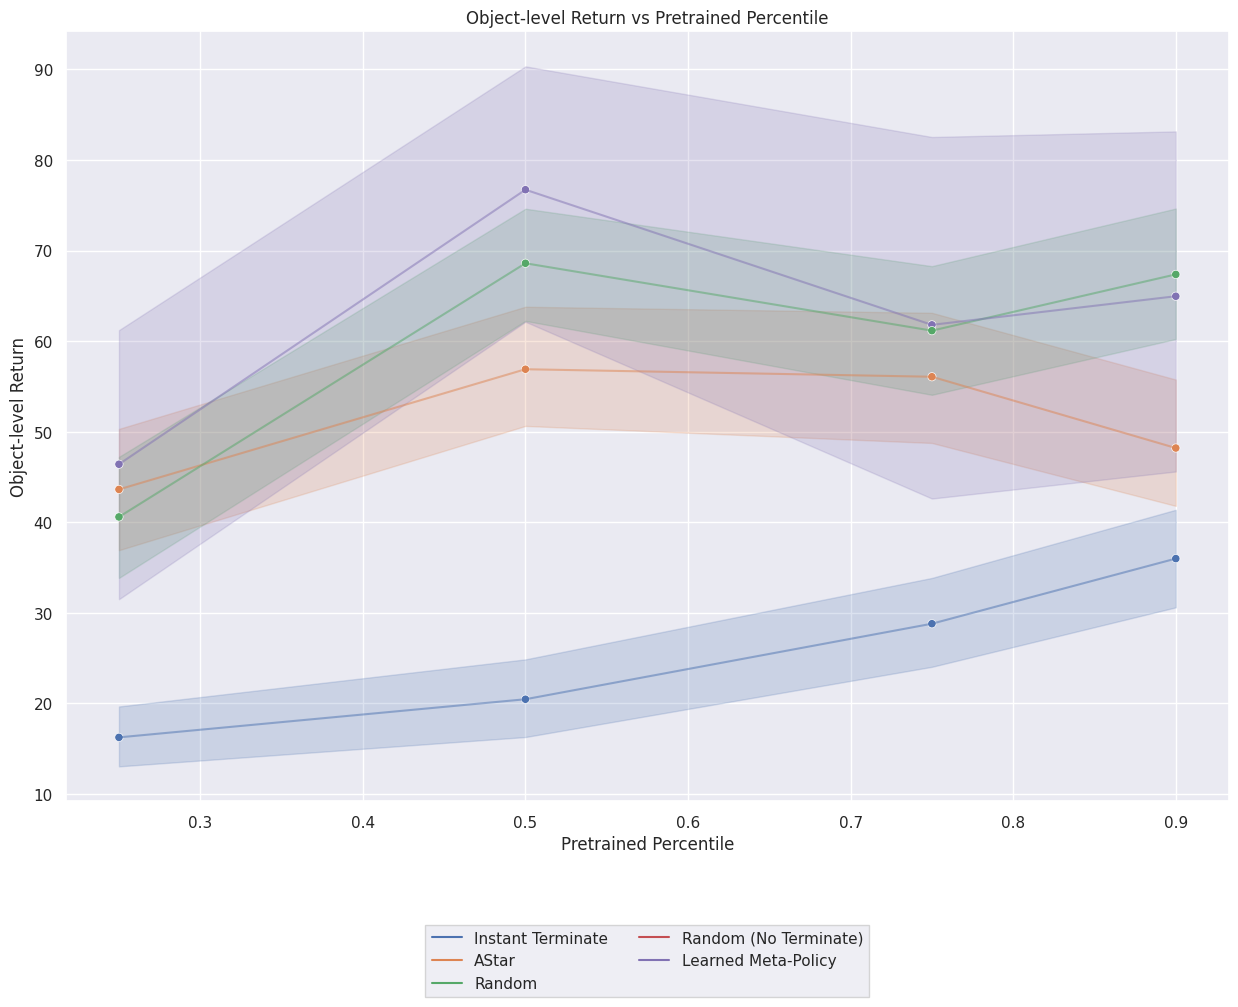

In [122]:
plt.figure(figsize=(15, 10))

means_df.sort_values(by='Meta-level Policy', inplace=True)
episodes_df.sort_values(by='Meta-level Policy', inplace=True)

ax = sns.lineplot(data=episodes_df, x='Pretrained Percentile', y='Return', hue='Meta-level Policy', alpha=0.5, hue_order=policy_order)
sns.scatterplot(data=means_df, x='Pretrained Percentile', y='Return', hue='Meta-level Policy', legend=False, hue_order=policy_order)
# sns.scatterplot(data=mean_stats_df, x='Pretrained Percentile', y='Return', hue='Meta-level Policy', legend=False)

# plt.xlabel('Pretrained Percentile')

plt.ylabel('Object-level Return')
plt.title(f'Object-level Return vs Pretrained Percentile')

# plt.ylim([0, 100])
ax.legend(loc='upper center', bbox_to_anchor=(.5, -.15),
          ncol=2, fancybox=False, shadow=False)

# plt.setp(ax.get_legend().get_texts(), fontsize='10') 
# plt.setp(ax.get_legend().get_title(), fontsize='20') 
# plt.savefig(self.output_dir / 'object-return-vs-percentile.png')

plt.show()

In [18]:
means_df

,Meta-level Policy,Pretrained Percentile,index,Number of Steps,Return
0,AStar,0.25,149.500000,201.470000,43.620000
1,AStar,0.50,549.500000,254.370000,56.890000
2,AStar,0.75,949.500000,237.570000,56.060000
3,AStar,0.90,1349.500000,202.150000,48.190000
4,Instant Terminate,0.25,49.500000,136.040000,16.240000
5,Instant Terminate,0.50,449.500000,184.230000,20.450000
6,Instant Terminate,0.75,849.500000,227.230000,28.790000
7,Instant Terminate,0.90,1249.500000,230.400000,35.980000
8,Learned Meta-Policy,0.25,9.500000,205.750000,46.400000
9,Learned Meta-Policy,0.50,9.952381,327.095238,76.714286


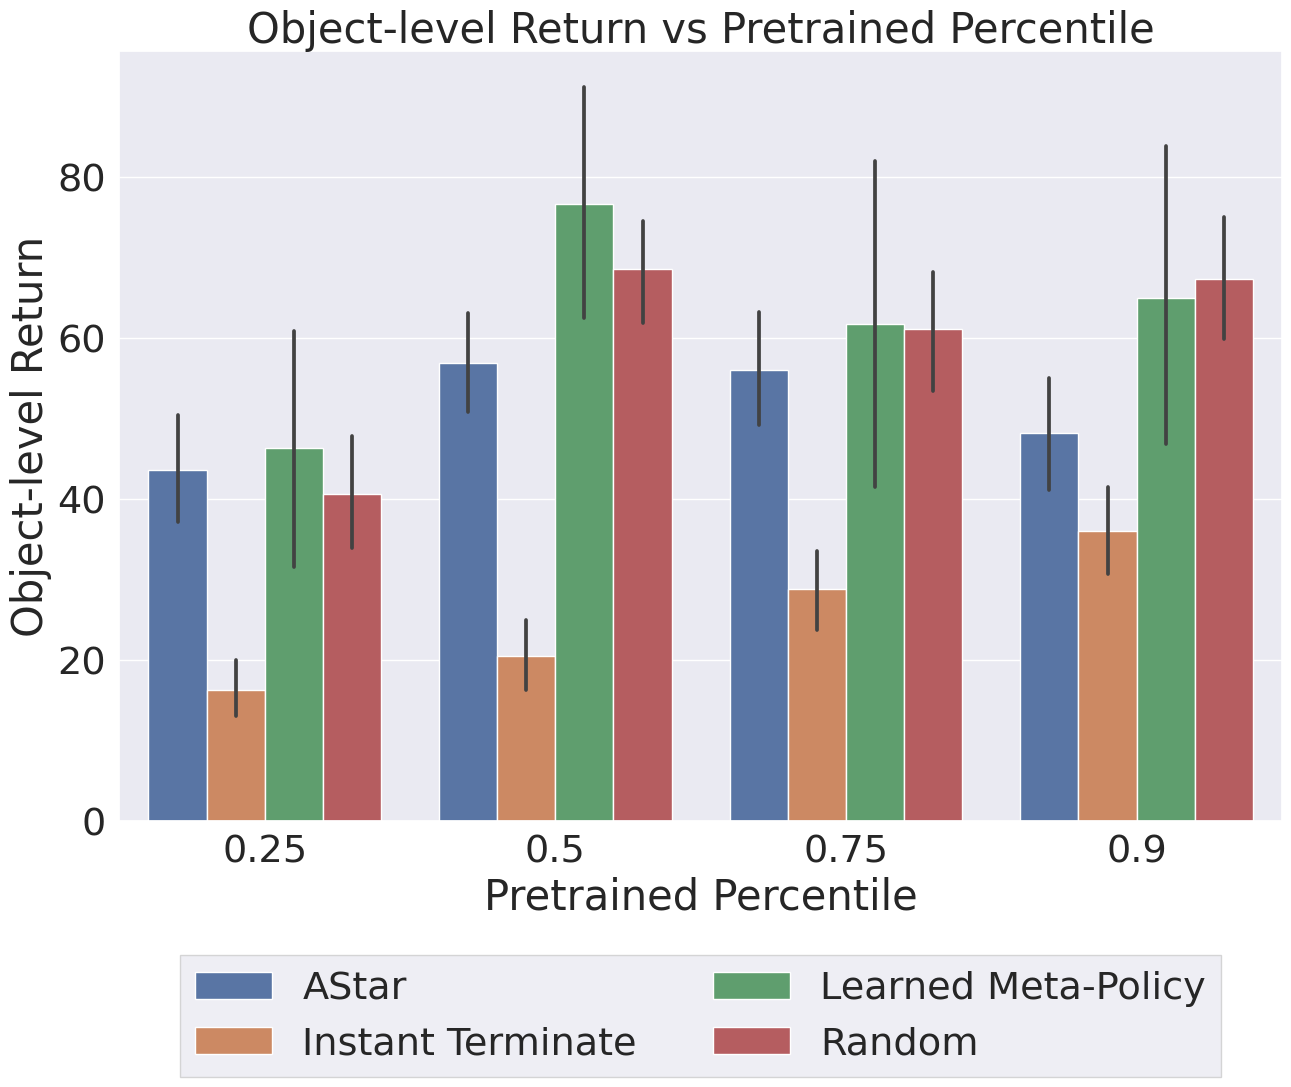

In [138]:
sns.set(font_scale=2.5)

plt.figure(figsize=(15, 10))

episodes_df = episode_stats_df.copy()
episodes_df = episodes_df[episodes_df['Meta-level Policy'] != 'Random']
episodes_df['Meta-level Policy'] = episodes_df['Meta-level Policy'].apply(lambda x: 'Random' if 'Random' in x else x)
means_df = episodes_df.groupby(['Meta-level Policy', 'Pretrained Percentile']).mean().reset_index()
means_df.sort_values(by='Meta-level Policy', inplace=True)
episodes_df.sort_values(by='Meta-level Policy', inplace=True)
policy_order = episodes_df['Meta-level Policy'].unique()

# ax = sns.lineplot(data=episodes_df, x='Pretrained Percentile', y='Return', hue='Meta-level Policy', alpha=0.5)
ax = sns.barplot(data=episodes_df, x='Pretrained Percentile', y='Return', hue='Meta-level Policy', hue_order=policy_order)
# sns.scatterplot(data=mean_stats_df, x='Pretrained Percentile', y='Return', hue='Meta-level Policy', legend=False)

# plt.xlabel('Pretrained Percentile')

plt.ylabel('Object-level Return')
plt.title(f'Object-level Return vs Pretrained Percentile')

# plt.ylim([0, 100])
ax.legend(loc='upper center', bbox_to_anchor=(.5, -.15),
          ncol=2, fancybox=False, shadow=False)

# plt.setp(ax.get_legend().get_texts(), fontsize='10') 
# plt.setp(ax.get_legend().get_title(), fontsize='20') 
# plt.savefig(self.output_dir / 'object-return-vs-percentile.png')

plt.show()

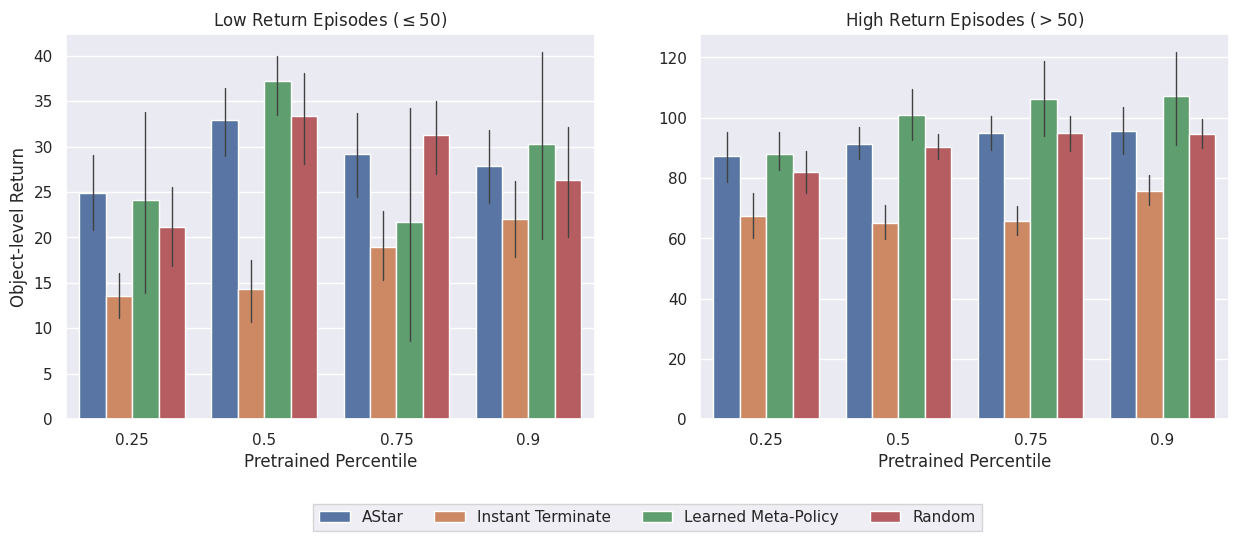

In [150]:
sns.set(font_scale=1)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

return_t = 50

episodes_df = episode_stats_df.copy()
episodes_df = episodes_df[episodes_df['Return'] <= return_t]
episodes_df = episodes_df[episodes_df['Meta-level Policy'] != 'Random']
episodes_df['Meta-level Policy'] = episodes_df['Meta-level Policy'].apply(lambda x: 'Random' if 'Random' in x else x)
means_df = episodes_df.groupby(['Meta-level Policy', 'Pretrained Percentile']).mean().reset_index()
means_df.sort_values(by='Meta-level Policy', inplace=True)
episodes_df.sort_values(by='Meta-level Policy', inplace=True)
policy_order = episodes_df['Meta-level Policy'].unique()

sns.barplot(data=episodes_df, x='Pretrained Percentile', y='Return', hue='Meta-level Policy',
            ax=axs[0], hue_order=policy_order, errwidth=1)

axs[0].set_ylabel('Object-level Return')
axs[0].set_title(f'Low Return Episodes ($\leq {return_t}$)')

axs[0].legend(loc='upper center', bbox_to_anchor=(1.1, -.2),
              ncol=4, fancybox=False, shadow=False)


episodes_df = episode_stats_df.copy()
episodes_df = episodes_df[episodes_df['Return'] > return_t]
episodes_df = episodes_df[episodes_df['Meta-level Policy'] != 'Random']
episodes_df['Meta-level Policy'] = episodes_df['Meta-level Policy'].apply(lambda x: 'Random' if 'Random' in x else x)
means_df = episodes_df.groupby(['Meta-level Policy', 'Pretrained Percentile']).mean().reset_index()
means_df.sort_values(by='Meta-level Policy', inplace=True)
episodes_df.sort_values(by='Meta-level Policy', inplace=True)

sns.barplot(data=episodes_df, x='Pretrained Percentile', y='Return', hue='Meta-level Policy',
            ax=axs[1], hue_order=policy_order, errwidth=1)

axs[1].set_ylabel('')
axs[1].set_title(f'High Return Episodes ($> {return_t}$)')
# remove legend
axs[1].legend([],[], frameon=False)

plt.show()

/tmp/ipykernel_12830/3750295276.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Return Interval'] = df['Rounded Return'].apply(lambda x: f'[{x}, {x + n})')
/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/tmp/ipykernel_12830/3750295276.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

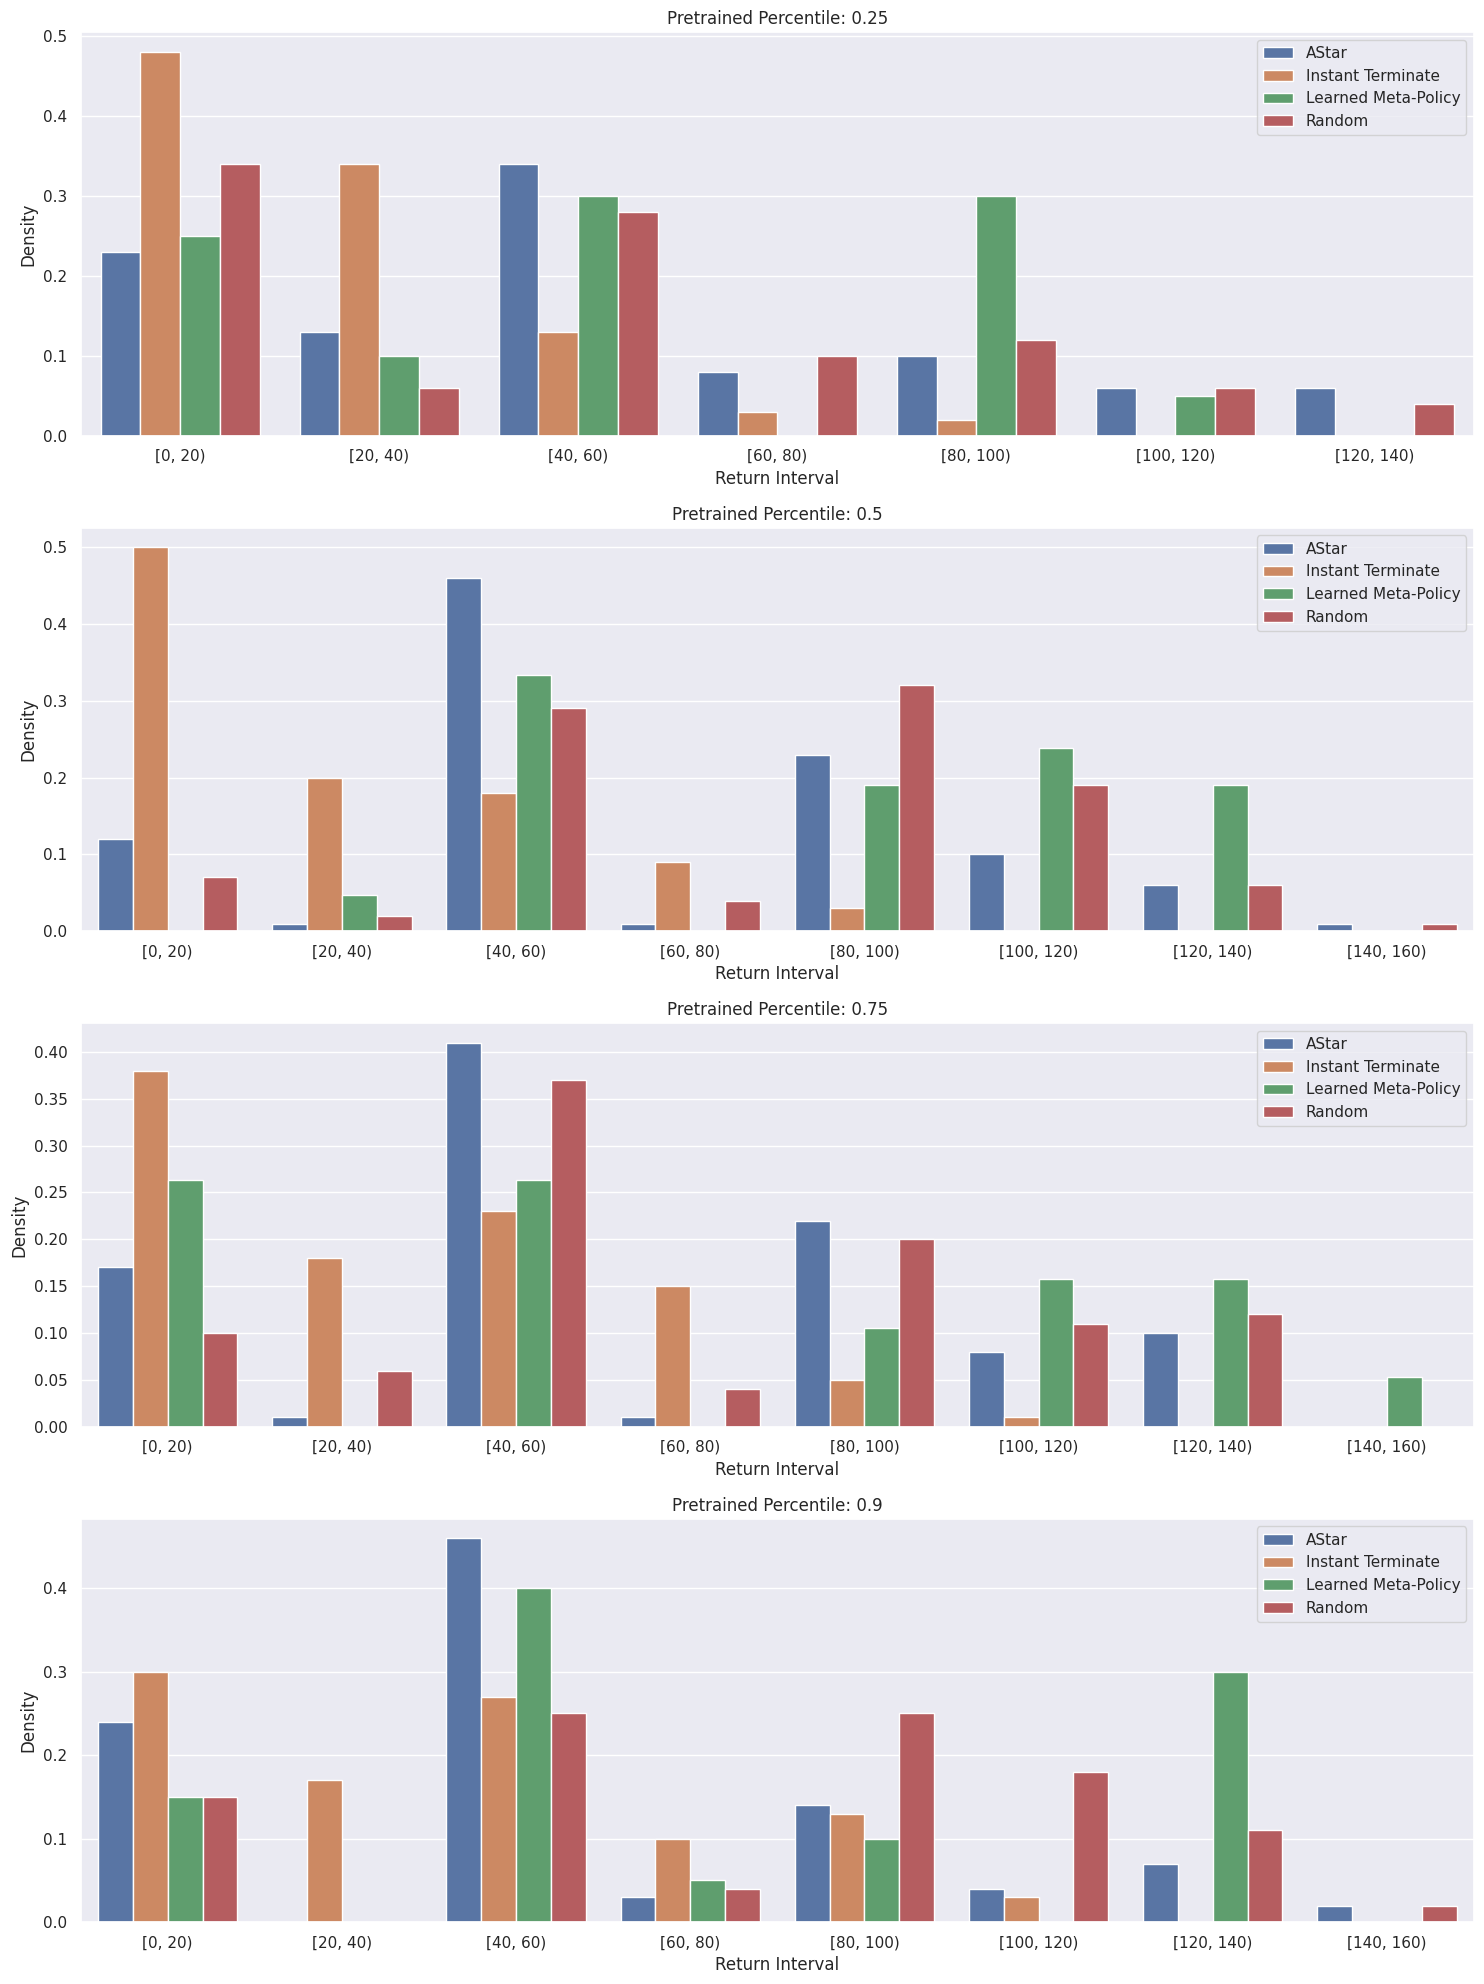

In [141]:
sns.set(font_scale=1)

episodes_df = episode_stats_df.copy()
episodes_df = episodes_df[episodes_df['Meta-level Policy'] != 'Random']
episodes_df['Meta-level Policy'] = episodes_df['Meta-level Policy'].apply(lambda x: 'Random' if 'Random' in x else x)
episodes_df.sort_values(by='Meta-level Policy', inplace=True)

n = 20
def round_return(x):
    return round(x / n) * n

episodes_df['Rounded Return'] = episodes_df['Return'].apply(round_return)
counts_df = episodes_df.groupby(['Meta-level Policy', 'Pretrained Percentile', 'Rounded Return']).count().reset_index()
counts_df.rename(columns={'Return': 'Count'}, inplace=True)
counts_df.drop(columns=['index', 'Number of Steps'], inplace=True)

total_episodes = episodes_df.groupby(['Meta-level Policy', 'Pretrained Percentile']).count().reset_index()
total_episodes.rename(columns={'index': 'Count'}, inplace=True)
total_episodes = total_episodes[['Meta-level Policy', 'Pretrained Percentile', 'Count']]

def normalize_counts(row):
    index, data = row
    right_policy = total_episodes['Meta-level Policy'] == data['Meta-level Policy']
    right_percentile = total_episodes['Pretrained Percentile'] == data['Pretrained Percentile']
    n = total_episodes[right_policy & right_percentile]['Count'].values[0]
    data['Density'] = data['Count'] / n
    return data

counts_df = pd.DataFrame(map(normalize_counts, counts_df.iterrows()))


fig, axs = plt.subplots(4, 1, figsize=(15, 20))

for percentile, ax in zip(sorted(episodes_df['Pretrained Percentile'].unique()),axs):
    # right_percentile = episodes_df['Pretrained Percentile'] == percentile
    # for policy in episodes_df['Meta-level Policy'].unique():
    #     right_policy = episodes_df['Meta-level Policy'] == policy
    #     sns.kdeplot(episodes_df[right_percentile & right_policy]['Return'], label=policy, ax=ax)
    df = counts_df[counts_df['Pretrained Percentile'] == percentile]
    df['Return Interval'] = df['Rounded Return'].apply(lambda x: f'[{x}, {x + n})')
    df.sort_values(by=['Rounded Return', 'Meta-level Policy'], inplace=True)
    sns.barplot(data=df, x='Return Interval', y='Density', hue='Meta-level Policy', ax=ax, hue_order=policy_order)
    ax.set_title(f'Pretrained Percentile: {percentile}')
    # ax.set_xlim([0, 80])

    ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [151]:
# episodes_df = episode_stats_df.copy()
# episodes_df = episodes_df[episodes_df['Meta-level Policy'] != 'Random']
# episodes_df['Meta-level Policy'] = episodes_df['Meta-level Policy'].apply(lambda x: 'Random' if 'Random' in x else x)
# means_df = episodes_df.groupby(['Meta-level Policy', 'Pretrained Percentile']).mean().reset_index()
# means_df.sort_values(by='Meta-level Policy', inplace=True)
# episodes_df.sort_values(by='Meta-level Policy', inplace=True)

# for percentile in episodes_df['Pretrained Percentile'].unique():
#     fig, ax = plt.subplots(figsize=(15, 5))
#     right_percentile = episodes_df['Pretrained Percentile'] == percentile
#     for policy in episodes_df['Meta-level Policy'].unique():
#         right_policy = episodes_df['Meta-level Policy'] == policy
#         sns.kdeplot(episodes_df[right_percentile & right_policy]['Return'], label=policy, ax=ax)
#     ax.set_title(f'Pretrained Percentile: {percentile}')
#     ax.set_xlim([0, 80])
#     ax.legend()
#     plt.show()

Text(0.5, 1.0, 'Mean Meta-level Return vs Pretrained Percentile')

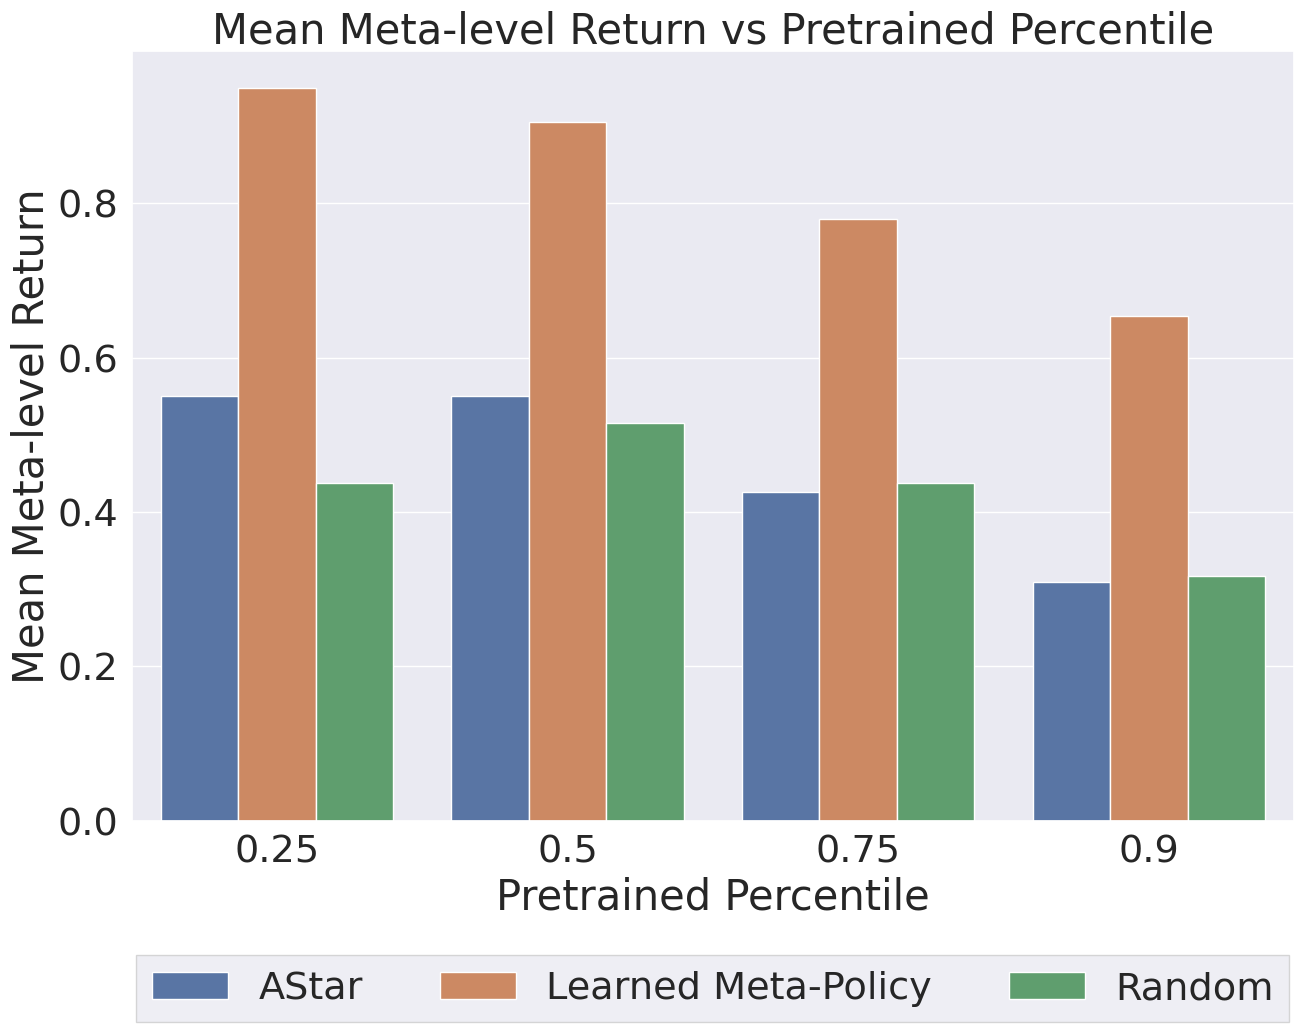

In [170]:

plot_name, plot_key = 'Mean Meta-level Return', 'EvalRewrittenAverageReturn'

plt.figure(figsize=(15, 10))

means_df = results_df.groupby(['Meta-level Policy', 'pretrained_percentile']).mean().reset_index()
means_df = means_df[~means_df['Meta-level Policy'].isin(['Random', 'Instant Terminate'])]
means_df['Meta-level Policy'] = means_df['Meta-level Policy'].apply(lambda x: 'Random' if 'Random' in x else x)
means_df.sort_values(by='Meta-level Policy', inplace=True)

# sns.lineplot(data=means_df, x='pretrained_percentile', y=plot_key, hue='Meta-level Policy', alpha=0.25)
# ax = sns.scatterplot(data=means_df, x='pretrained_percentile', y=plot_key, hue='Meta-level Policy', legend=False)
ax = sns.barplot(data=means_df, x='pretrained_percentile', y=plot_key, hue='Meta-level Policy', )

ax.legend(loc='upper center', bbox_to_anchor=(.5, -.15),
          ncol=3, fancybox=False, shadow=False)

plt.xlabel('Pretrained Percentile')
plt.ylabel(plot_name)
plt.title(f'{plot_name} vs Pretrained Percentile')


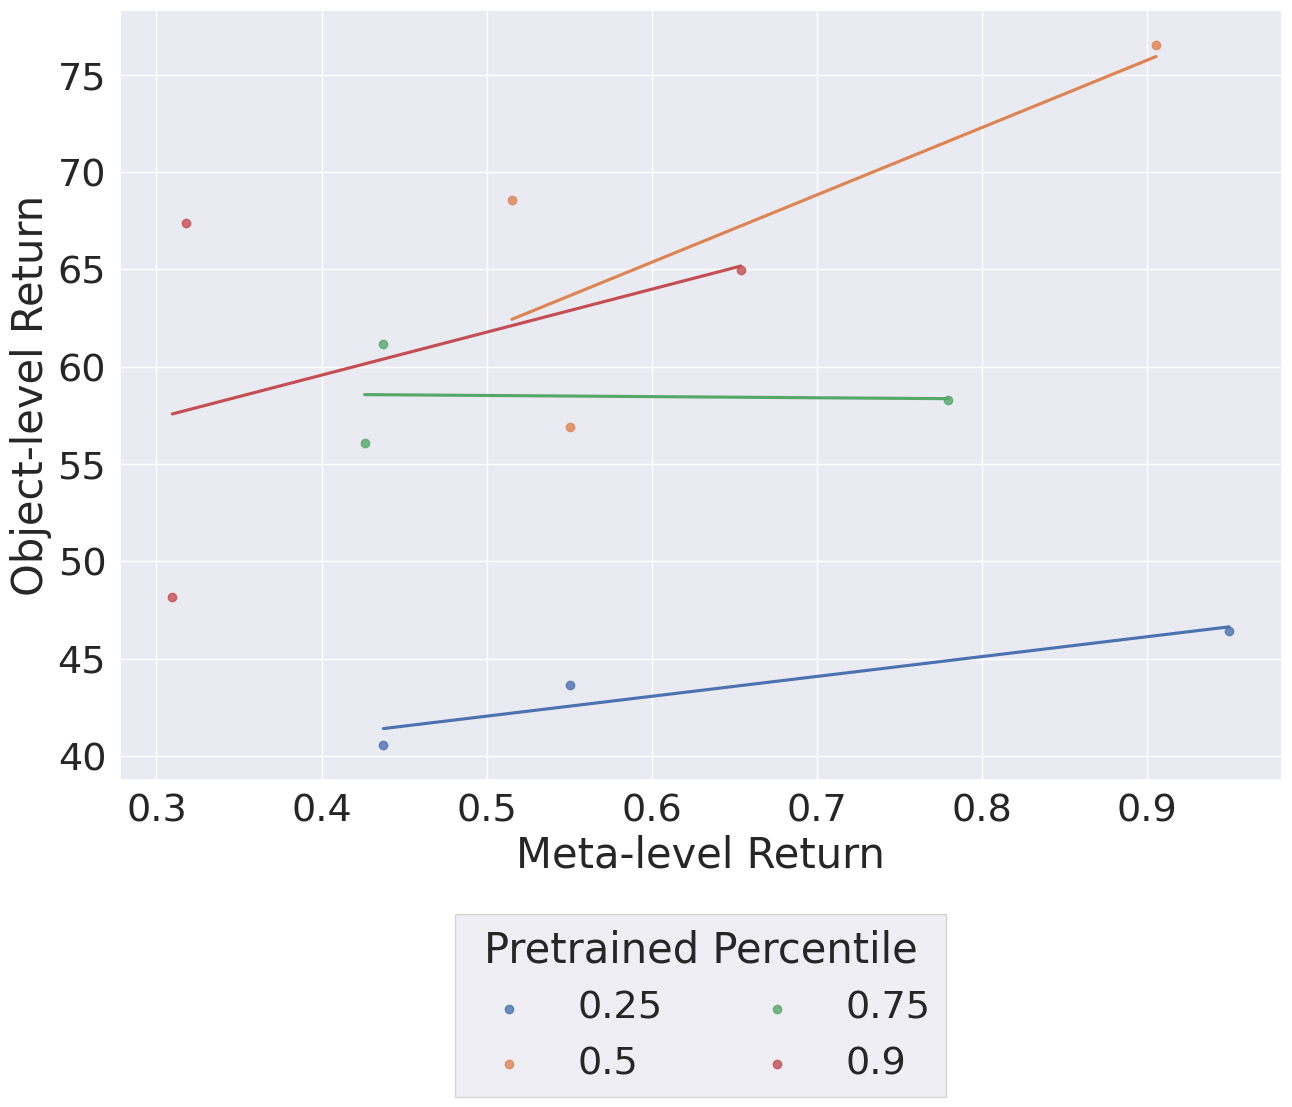

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

In [184]:
means_df = results_df.groupby(['Meta-level Policy', 'pretrained_percentile']).mean().reset_index()
# means_df = means_df[means_df['Meta-level Policy'] != 'Random']
means_df = means_df[~means_df['Meta-level Policy'].isin(['Random', 'Instant Terminate'])]
means_df['Meta-level Policy'] = means_df['Meta-level Policy'].apply(lambda x: 'Random' if 'Random' in x else x)
means_df.sort_values(by='Meta-level Policy', inplace=True)

ax = None
for percentile in means_df['pretrained_percentile'].unique():
    plot_name, plot_key = 'Mean Rewritten Meta Return', 'EvalRewrittenAverageReturn'

    plt.figure(figsize=(15, 10))

    # sns.lineplot(data=means_df, x='pretrained_percentile', y=plot_key, hue='Meta-level Policy', alpha=0.25)
    ax = sns.regplot(data=means_df[means_df['pretrained_percentile'] == percentile], label=percentile,
                x='EvalRewrittenAverageReturn', y='ObjectLevelMeanReward', scatter=True, ci=None, ax=ax)
    # ax = sns.scatterplot(data=means_df, x='EvalRewrittenAverageReturn', y='ObjectLevelMeanReward', hue='pretrained_percentile')

ax.legend(title='Pretrained Percentile', loc='upper center', bbox_to_anchor=(.5, -.15),
          ncol=2, fancybox=False, shadow=False)

ax.set_xlabel('Meta-level Return')
ax.set_ylabel('Object-level Return')
plt.show()

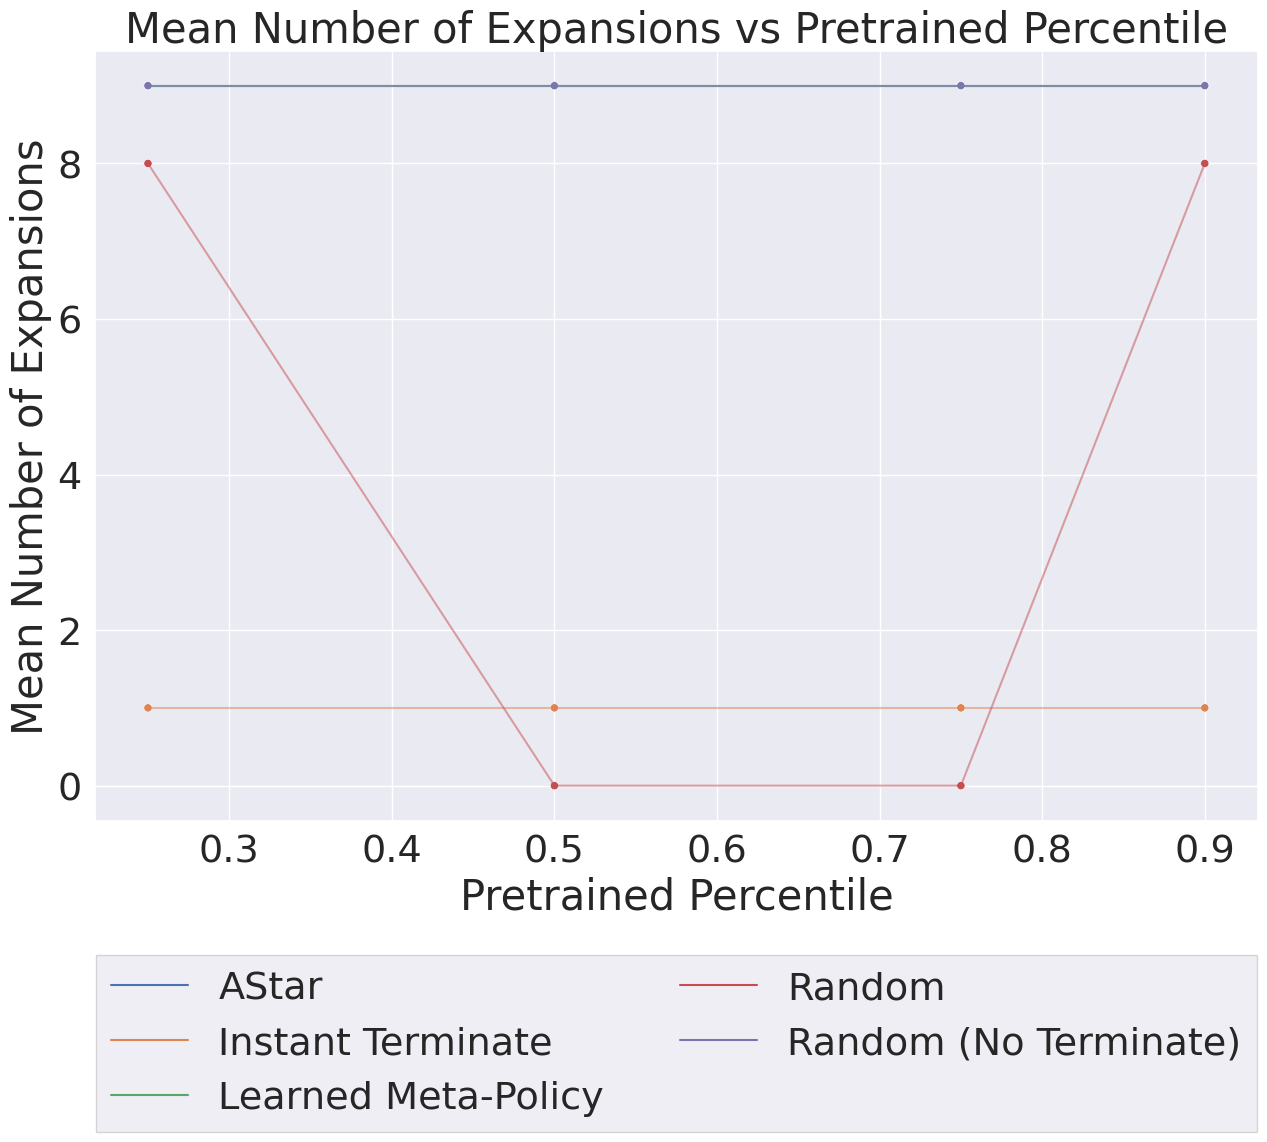

In [135]:
plt.figure(figsize=(15, 10))

means_df = results_df.groupby(['Meta-level Policy', 'pretrained_percentile']).mean().reset_index()
means_df.sort_values(by='Meta-level Policy', inplace=True)

ax = sns.lineplot(data=means_df, x='pretrained_percentile', y='EvalAverageEpisodeLength', hue='Meta-level Policy', alpha=0.5)
sns.scatterplot(data=means_df, x='pretrained_percentile', y='EvalAverageEpisodeLength', hue='Meta-level Policy', legend=False)

plt.xlabel('Pretrained Percentile')

plt.ylabel('Mean Number of Expansions')
plt.title(f'Mean Number of Expansions vs Pretrained Percentile')

# plt.ylim([0, 100])
ax.legend(loc='upper center', bbox_to_anchor=(.5, -.15),
          ncol=2, fancybox=False, shadow=False)

# plt.setp(ax.get_legend().get_texts(), fontsize='10') 
# plt.setp(ax.get_legend().get_title(), fontsize='20') 
# plt.savefig(self.output_dir / 'object-return-vs-percentile.png')

plt.show()